In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['text.usetex'] = True
plt.rc('font', family = 'roman')

import SMBHBpy
from SMBHBpy import constants as c
from SMBHBpy import merger_system as ms

from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

C:\Users\matthias\AppData\Local\Temp\ipykernel_12852\1537006237.py:37: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour = CS.collections[0]


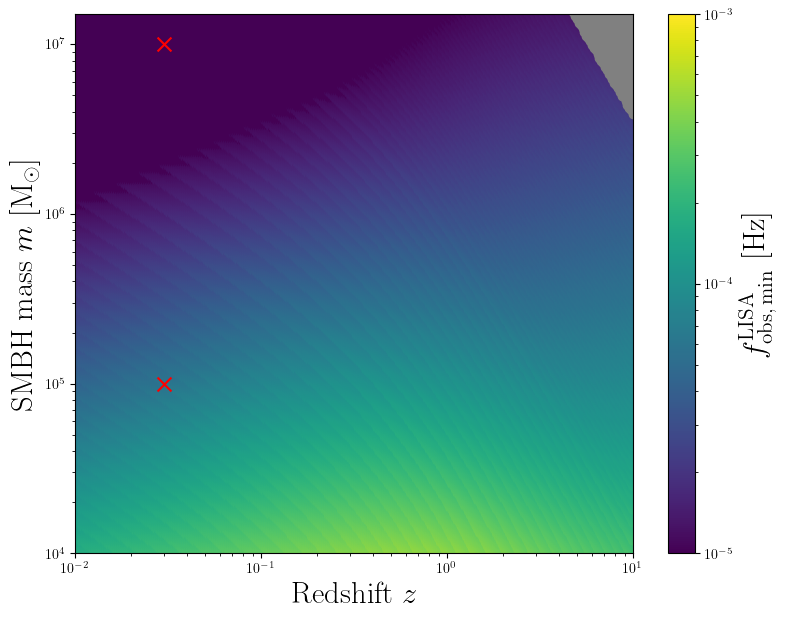

In [2]:
# Load data
data = np.load("fmin_LISA_results_300.npz")
M_mesh = data["M_mesh"]
Z_mesh = data["Z_mesh"]
fmin_grid = data["fmin_grid"] / c.hz_to_invpc

# Prepare plot data: we will plot points (z, m) with color given by f_min
fig, ax = plt.subplots(figsize=(9,7))
cmap = plt.cm.viridis 

# Flatten arrays for scatter plot
Z_flat = Z_mesh.flatten()
M_flat = M_mesh.flatten() / c.solar_mass_to_pc 
fmin_flat = fmin_grid.flatten()

# Plot valid points
mask_valid = ~np.isnan(fmin_flat)
sc = ax.scatter(Z_flat[mask_valid], M_flat[mask_valid],
                c=fmin_flat[mask_valid], cmap=cmap, norm=LogNorm(vmin=np.nanmin(fmin_grid), vmax=1e-3))

# Plot NaN points (no detection) in gray
mask_nan = np.isnan(fmin_flat)
if np.any(mask_nan):
    ax.scatter(Z_flat[mask_nan], M_flat[mask_nan], color='grey')

# Fit black contour at f_min = 1e-5 Hz transition
tol = 1*1e-7  # tolerance around 1e-5 Hz
Lisa = SMBHBpy.detector.Lisa()
f_LISA_min = Lisa.Bandwith()[0]/c.hz_to_invpc

mask_target = (fmin_grid >= f_LISA_min - tol) & (fmin_grid <= f_LISA_min + tol)
mask_int = mask_target.astype(int)
fig_tmp, ax_tmp = plt.subplots()
CS = ax_tmp.contour(Z_mesh, M_mesh / c.solar_mass_to_pc, mask_int, levels=[0.5])
plt.close(fig_tmp)

contour = CS.collections[0] 
paths = contour.get_paths()

z_points = []
M_points = []

for path in paths:
    v = path.vertices
    z_points.extend(v[:, 0])
    M_points.extend(v[:, 1])

z_points = np.array(z_points)
M_points = np.array(M_points)

order = np.argsort(z_points)
z_points = z_points[order]
M_points = M_points[order]

def poly_log(x, a0, a1, a2):
    return a0 + a1 * x + a2 * x**2

logz = np.log10(z_points)
logM = np.log10(M_points)

popt, pcov = curve_fit(poly_log, logz, logM)

z_fit = np.logspace(np.log10(np.min(z_points)), np.log10(np.max(z_points)), 200)
logM_fit = poly_log(np.log10(z_fit), *popt)
M_fit = 10**logM_fit

#ax.plot(z_fit, M_fit, color='black', linestyle='dashed', linewidth=2,)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$f^\mathrm{LISA}_\mathrm{obs,\,min}\ \mathrm{[Hz]}$", fontsize=22)

plt.scatter(0.03, 1e5, color = "red", s = 100, marker='x')
plt.scatter(0.03, 1e7, color = "red", s = 100, marker='x')


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Redshift $z$", fontsize = 22)
ax.set_ylabel("SMBH mass $m$ [$\mathrm{M_\odot}$]", fontsize = 22)
plt.ylim(1e4, 1.5*1e7)
plt.xlim(0.01,10)

#plt.savefig("fmin_LISA_m_z_without_black_line.png", dpi=300, bbox_inches='tight')
plt.show()